# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [3]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from joblib import delayed, Parallel

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, RobertaTokenizerFast, RobertaForSequenceClassification, pipeline, get_linear_schedule_with_warmup

In [4]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [28]:
class Subjectivity:
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        dataset_dict = {
            'english': {
                'train': ...
                'dev': ...
                'test': ...
            },
        }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        print(dataset['label'].value_counts(normalize=True))

    def get_baseline_model(self, model_name: str = "paraphrase-multilingual-MiniLM-L12-v2"):
        vect = SentenceTransformer(model_name)
        self.vect = vect
        return vect

    def train_baseline_model(self, vect, train_data: pd.DataFrame, test_data: pd.DataFrame, solver: str = 'saga'):
        model = LogisticRegression(class_weight="balanced", solver=solver, random_state=self.seed)
        model.fit(X=vect.encode(train_data['sentence'].values), y=train_data['label'].values)
        predictions = model.predict(X=vect.encode(test_data['sentence'].values)).tolist()

        # eval performances
        perfs = self.evaluate_model(gold_values=test_data['label'].values, predicted_values=predictions)

        return perfs

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        return class_weights

    def tokenize_text(self, sentences: pd.Series, max_length: int = 100):
        input_ids = []
        attention_masks = []
        total_length = 0
        i = 0
        for sent in tqdm(sentences, desc='Tokenize of sentences'):
            total_length += len(sent)
            i += 1
            encoded = self.tokenizer.encode_plus(
                sent,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask = True,
                return_tensors = 'pt')

            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        return input_ids, attention_masks

    def create_dataloader(self, input_ids, attention_masks, labels, batch_size: int, shuffle: bool = True, pin_mem: bool = False):
        dataset = TensorDataset(input_ids, attention_masks, labels)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_mem)

    def train_model(self, model, model_name: str, train_dl, dev_dl, criterion, optimizer, scheduler, epochs: int, device):

        # Resize model token embeddings to the len of tokenizer
        model.resize_token_embeddings(len(self.tokenizer))

        # Move model to device
        model.to(device)
        
        true_labels = defaultdict(list)
        predictions = defaultdict(list)
        val_losses = {}
        training_stats = []
        
        best_val_loss = float('inf')
        for i, epoch in enumerate(range(epochs), start=1):
        
            total_train_loss = 0
            model.train()
        
            for batch in tqdm(train_dl, desc=f"Epoch {i}/{epochs}"):
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)
        
                model.zero_grad()
        
                result = model(b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels,
                return_dict=True)
        
                logits = result.logits
        
                # Compute weighted loss manually
                loss = criterion(logits, b_labels) # Use weighted loss
                total_train_loss += loss.item()
        
                loss.backward()
        
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
                optimizer.step()
                scheduler.step()
                
            avg_train_loss = total_train_loss / len(train_dl)
        
            model.eval()
        
            total_eval_loss = 0
        
            for batch in tqdm(dev_dl, desc="Evaluating"):
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)
        
                with torch.no_grad():
                    result = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels,
                                return_dict=True)
        
                logits = result.logits
        
                loss = criterion(logits, b_labels) # Use weighted loss
                total_eval_loss += loss.item()
        
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
        
                true_labels[i].append(label_ids)
                predictions[i].append(logits)
        
            # Printing the cr
            flat_predictions = np.concatenate(predictions[i], axis=0)
            flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
            flat_true_labels = np.concatenate(true_labels[i], axis=0)
            
            stats = self.evaluate_model(flat_true_labels, flat_predictions)
        
            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(dev_dl)
            val_losses[i] = avg_val_loss
        
            print(f"Epoch {i}/{epochs}\tTrain Loss: {avg_train_loss:.6f}\tVal Loss: {avg_val_loss:.6f}\tL.rate: {optimizer.param_groups[0]['lr']:.6f}\tVal F1: {stats['macro_F1']:.4f}")
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                print("Saving model with new val loss:", best_val_loss)
                torch.save(model.state_dict(), model_name)
        
            training_stats.append(stats)

        print("Loading the best model checkpoint")
        model.load_state_dict(torch.load(model_name, weights_only=True))

        return model

    def evaluate_model(self, gold_values, predicted_values):
        acc = accuracy_score(gold_values, predicted_values)
        m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                                   zero_division=0)
        p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                                   zero_division=0)
    
        return {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }

In [29]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

In [30]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


In [31]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


In [32]:
#notebook_login()

# Baseline Model (English)

In [11]:
vect = detector.get_baseline_model(model_name="paraphrase-multilingual-MiniLM-L12-v2")
vect

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [12]:
detector.train_baseline_model(vect, detector.all_data['english']['train'], detector.all_data['english']['test'])

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

{'macro_F1': 0.6328683996014854,
 'macro_P': 0.6328683996014853,
 'macro_R': 0.6328683996014853,
 'SUBJ_F1': 0.4508196721311476,
 'SUBJ_P': 0.45081967213114754,
 'SUBJ_R': 0.45081967213114754,
 'accuracy': 0.7231404958677686}

# Baseline Model (italian)

In [13]:
detector.train_baseline_model(vect, detector.all_data['italian']['train'], detector.all_data['italian']['test'])

Batches:   0%|          | 0/51 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

{'macro_F1': 0.6320502510378404,
 'macro_P': 0.6294871794871795,
 'macro_R': 0.656605944765174,
 'SUBJ_F1': 0.5015105740181269,
 'SUBJ_P': 0.4256410256410256,
 'SUBJ_R': 0.6102941176470589,
 'accuracy': 0.6783625730994152}

# Baseline Model (multilingual)

In [14]:
detector.train_baseline_model(vect, detector.train, detector.test)

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

{'macro_F1': 0.6220011992495018,
 'macro_P': 0.6223227143343395,
 'macro_R': 0.633496534725811,
 'SUBJ_F1': 0.538037486218302,
 'SUBJ_P': 0.4807881773399015,
 'SUBJ_R': 0.6107634543178974,
 'accuracy': 0.6406518010291595}

# mDeBERTta v3 base (German)

In [33]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


4788

In [34]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [35]:
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
language = 'german'

epochs = 5
batch_size = 16
lr = 1e-5
weight_decay = 0.3
n_warmup_steps = 200
label_smoothing = 0.1

# Get the data
X_train, y_train = detector.all_data[language]['train']['sentence'], detector.all_data[language]['train']['label']
X_dev, y_dev = detector.all_data[language]['dev']['sentence'], detector.all_data[language]['dev']['label']
X_test, y_test = detector.all_data[language]['test']['sentence'], detector.all_data[language]['test']['label']

# Convert y to tensor
y_train = torch.tensor(y_train.values)
y_dev = torch.tensor(y_dev.values)
y_test = torch.tensor(y_test.values)

# Tokenize the text
train_input_ids, train_attention_masks = detector.tokenize_text(X_train)
dev_input_ids, dev_attention_masks = detector.tokenize_text(X_dev)
test_input_ids, test_attention_masks = detector.tokenize_text(X_test)

# Create dataloaders
train_dl = detector.create_dataloader(train_input_ids, train_attention_masks, y_train, batch_size=batch_size, shuffle=True, pin_mem=True)
dev_dl = detector.create_dataloader(dev_input_ids, dev_attention_masks, y_dev, batch_size=batch_size, shuffle=False, pin_mem=True)
test_dl = detector.create_dataloader(test_input_ids, test_attention_masks, y_test, batch_size=batch_size, shuffle=False, pin_mem=False)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_dl) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

Tokenize of sentences: 100%|██████████| 337/337 [00:00<00:00, 2970.74it/s]


In [37]:
model = detector.train_model(model, "mDeBERTa-base-subjectivity.pth", train_dl, dev_dl, criterion, optimizer, scheduler, epochs, device)

Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.19it/s]


Epoch 1/5	Train Loss: 0.706034	Val Loss: 0.697733	L.rate: 0.000003	Val F1: 0.3923
Saving model with new val loss: 0.6977327292965304


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.27it/s]


Epoch 2/5	Train Loss: 0.700585	Val Loss: 0.694488	L.rate: 0.000005	Val F1: 0.4710
Saving model with new val loss: 0.6944883369630382


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.09it/s]


Epoch 3/5	Train Loss: 0.650890	Val Loss: 0.627306	L.rate: 0.000008	Val F1: 0.7340
Saving model with new val loss: 0.6273060729426723


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.06it/s]


Epoch 4/5	Train Loss: 0.555607	Val Loss: 0.590654	L.rate: 0.000010	Val F1: 0.7751
Saving model with new val loss: 0.5906543106802048


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.14it/s]


Epoch 5/5	Train Loss: 0.489816	Val Loss: 0.583956	L.rate: 0.000000	Val F1: 0.7596
Saving model with new val loss: 0.5839562214189961
Loading the best model checkpoint


In [38]:
results_df = pd.DataFrame(columns=['model','f1','acc','lang'])

Predicting: 100%|██████████| 22/22 [00:01<00:00, 15.63it/s]


{'macro_F1': 0.8130968346963265, 'macro_P': 0.8171404067630483, 'macro_R': 0.8095551303515905, 'SUBJ_F1': 0.7465437788018433, 'SUBJ_P': 0.7641509433962265, 'SUBJ_R': 0.7297297297297297, 'accuracy': 0.8367952522255193}


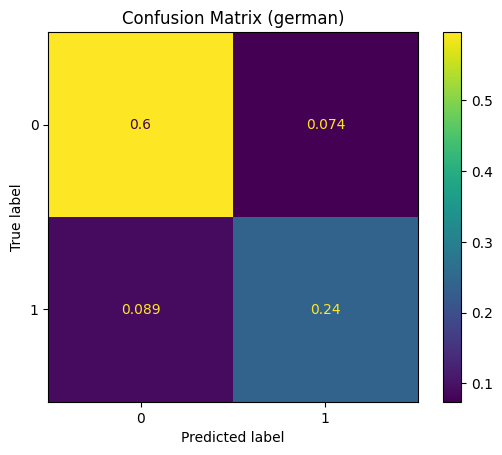

In [42]:
model.eval()

labels = []
predictions = []

with torch.no_grad():
    for batch in tqdm(test_dl, desc="Predicting"):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

        logits = result.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        labels.extend(label_ids)
        logits = np.argmax(logits, axis=1)
        predictions.extend(logits)
    
    labels = np.array(labels)
    predictions = np.array(predictions)

    results_df.loc[len(results_df)] = [model_card, f1_macro, acc, language]

    print(detector.evaluate_model(gold_values=labels, predicted_values=predictions))
    
    ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='all')
    plt.title(f"Confusion Matrix ({language})")
    plt.show()

In [43]:
results_df

,model,f1,acc,lang
0,microsoft/mdeberta-v3-base,0.813097,0.836795,german
1,microsoft/mdeberta-v3-base,0.813097,0.836795,german
2,microsoft/mdeberta-v3-base,0.813097,0.836795,german
3,microsoft/mdeberta-v3-base,0.813097,0.836795,german


# Emotions

In [ ]:
model_card = "arpanghoshal/EmoRoBERTa"
tokenizer = RobertaTokenizerFast.from_pretrained(model_card)
model = RobertaForSequenceClassification.from_pretrained(model_card, from_tf=True)

In [ ]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa', return_all_scores= True)

In [ ]:
# Example
print(train_data.iloc[0]['sentence'], train_data.iloc[0]['label'])
emotion_labels = emotion(train_data.iloc[0]['sentence'])
pd.DataFrame(emotion_labels[0]).sort_values(by='score', ascending=False)

In [ ]:
emotion_array = np.zeros((train_data.shape[0], 28))

for i, sentence in enumerate(tqdm(train_data['sentence'])):
    result = emotion(sentence)[0]
    emotion_array[i] = np.array([list(d.values())[1] for d in result])

In [ ]:
emotion_df_train = pd.DataFrame(emotion_array, columns=[list(d.values())[0] for d in result])
emotion_df_train.head()

In [ ]:
train_data_augmented = pd.concat([train_data, emotion_df_train], axis=1)
train_data_augmented.head()

In [ ]:
emotion_array = np.zeros((test_data.shape[0], 28))

for i, sentence in enumerate(tqdm(test_data['sentence'])):
    result = emotion(sentence)[0]
    emotion_array[i] = np.array([list(d.values())[1] for d in result])

In [ ]:
emotion_df_test = pd.DataFrame(emotion_array, columns=[list(d.values())[0] for d in result])
emotion_df_test.head()

In [ ]:
test_data_augmented = pd.concat([test_data, emotion_df_test], axis=1)
test_data_augmented.head()

In [ ]:
if not os.path.exists('/kaggle/input/clef2025-checkthat/data/english/train_en_aug.csv'):
    train_data_augmented.to_csv('train_en_aug.csv', encoding='UTF-8')
    test_data_augmented.to_csv('dev_test_en_aug.csv', encoding='UTF-8')
else:
    train_data_augmented = pd.read_csv('/kaggle/input/clef2025-checkthat/data/english/train_en_aug.csv', encoding='UTF-8', index_col=0)
    test_data_augmented = pd.read_csv('/kaggle/input/clef2025-checkthat/data/english/dev_test_en_aug.csv', encoding='UTF-8', index_col=0)

In [ ]:
def preprocess(text):
    preprocessed_text = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
        preprocessed_text.append(t)
    return ' '.join(preprocessed_text)

In [ ]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.logits
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [ ]:
class CustomEmotionModel(nn.Module):
    def __init__(self, model_card: str, num_labels: int, num_emotions: int, class_weights: torch.Tensor, device):
        super(CustomEmotionModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_card)
        #self.emotion_branch = nn.Linear(num_emotions, 128)  # Example: 128 hidden units
        self.classifier = nn.Linear(self.base_model.config.hidden_size + 28, num_labels)
        self.class_weights = class_weights.to(device)

    def forward(self, input_ids, attention_mask, emotion_features, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation
        
        # Process emotion features
        #emotion_output = torch.relu(self.emotion_branch(emotion_features))
        
        # Concatenate base model output with emotion features
        combined_output = torch.cat((pooled_output, emotion_features), dim=1)
        
        # Apply classification layer
        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = criterion(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

In [ ]:
train_data_augmented['all_emotions'] = train_data_augmented[train_data_augmented.columns[-28:]].apply(lambda x: np.array(x.values, dtype=np.float32), axis=1)
test_data_augmented['all_emotions'] = test_data_augmented[test_data_augmented.columns[-28:]].apply(lambda x: np.array(x.values, dtype=np.float32), axis=1)

In [ ]:
train_dl = Dataset.from_pandas(train_data_augmented)
test_dl = Dataset.from_pandas(test_data_augmented)

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_data['label']), y=train_data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights

In [ ]:
model_card = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)
model = CustomEmotionModel(model_card, num_labels = 2, num_emotions=28, class_weights=class_weights, device=device)

In [ ]:
def tokenize_and_prepare(texts):
    tokenized = tokenizer(texts['sentence'])
    return {**tokenized, 'emotion_features': texts['all_emotions']}

In [ ]:
train_dl = train_dl.map(tokenize_and_prepare, batched=True)
test_dl = test_dl.map(tokenize_and_prepare, batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
training_args = TrainingArguments(
    output_dir=f'model',                 
    learning_rate=5e-6,
    per_device_train_batch_size=16,         
    per_device_eval_batch_size=16,
    lr_scheduler_type='linear',
    label_smoothing_factor=0.1,
    num_train_epochs=10,
    weight_decay=1e-2,
    eval_strategy="epoch",       
    save_strategy="no",           
    #save_safetensors=True,
    #load_best_model_at_end=True,
    report_to='none',
    seed=SEED,
    data_seed=SEED
)

In [ ]:
def compute_metrics(output_info):
    """
    Compute various evaluation metrics for model predictions.
    
    Args:
        output_info (tuple): A tuple containing the model predictions and the true labels.
            - predictions (np.ndarray): The predicted labels from the model.
            - labels (np.ndarray): The true labels.
    
    Returns:
        dict: A dictionary containing the computed metrics:
            - 'f1': The F1 score (macro average).
            - 'accuracy': The accuracy score.
            - 'precision': The precision score (macro average).
            - 'recall': The recall score (macro average).
    """
    predictions, labels = output_info
    predictions = np.array(predictions)
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    return {"f1-score" : f1, "Accuracy" : acc}

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dl,
    eval_dataset=test_dl,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    device=device,
)

In [ ]:
trainer.train()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
prediction, labels, _ = trainer.predict(test_dl)
prediction = np.argmax(prediction, axis=1)
cm = confusion_matrix(y_true=labels, y_pred=prediction, normalize='all')
print(roc_auc_score(labels, prediction))

ConfusionMatrixDisplay(cm).plot()

---

In [ ]:
def objective(trial):
    epochs = trial.suggest_int('epochs', 3, 5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 4e-5, 5e-5, 6e-5])
    weight_decay = trial.suggest_categorical('weight_decay', [0, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1])
    n_warmup_steps = trial.suggest_categorical('n_warmup_steps', [100, 200, 300, 400, 500])

    model = AutoModelForSequenceClassification.from_pretrained(
        model_card, 
        num_labels=2, 
        id2label={0: 'OBJ', 1: 'SUBJ'}, 
        label2id={'OBJ': 0, 'SUBJ': 1},
        output_attentions = False,
        output_hidden_states = False
    )
    model.to(device)
    
    train_dl = create_dataloader(
        train_input_ids, 
        train_attention_masks, 
        torch.tensor(train['label'].values), 
        batch_size=batch_size,
        shuffle=True,
        pin_mem=True
    )
    dev_dl = create_dataloader(
        dev_input_ids, 
        dev_attention_masks, 
        torch.tensor(dev['label'].values), 
        batch_size=batch_size,
        shuffle=False,
        pin_mem=True
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_dl) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    true_labels = defaultdict(list)
    predictions = defaultdict(list)
    val_losses = {}
    training_stats = []
    
    best_val_loss = float('inf')
    for i, epoch in enumerate(range(epochs), start=1):
    
        total_train_loss = 0
        model.train()
    
        for batch in tqdm(train_dl, desc=f"Epoch {i}/{epochs}"):
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)
    
            model.zero_grad()
    
            result = model(b_input_ids,
              attention_mask=b_input_mask,
              labels=b_labels,
              return_dict=True)
    
            logits = result.logits
    
            # Compute weighted loss manually
            loss = criterion(logits, b_labels) # Use weighted loss
            total_train_loss += loss.item()
    
            loss.backward()
    
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            optimizer.step()
            scheduler.step()
            
        avg_train_loss = total_train_loss / len(train_dl)
    
        model.eval()
    
        total_eval_loss = 0
    
        for batch in tqdm(dev_dl, desc="Evaluating"):
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)
    
            with torch.no_grad():
                result = model(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask,
                              labels=b_labels,
                              return_dict=True)
    
            logits = result.logits
    
            loss = criterion(logits, b_labels) # Use weighted loss
            total_eval_loss += loss.item()
    
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
    
            true_labels[i].append(label_ids)
            predictions[i].append(logits)
    
        # Printing the cr
        flat_predictions = np.concatenate(predictions[i], axis=0)
        flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
        flat_true_labels = np.concatenate(true_labels[i], axis=0)
        
        stats = evaluate_model(flat_true_labels, flat_predictions)
    
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(dev_dl)
        val_losses[i] = avg_val_loss
    
        print(f"Epoch {i}/{epochs}\tTrain Loss: {avg_train_loss:.6f}\tVal Loss: {avg_val_loss:.6f}\tL.rate: {optimizer.param_groups[0]['lr']:.6f}\tVal F1: {stats['macro_F1']:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print("Saving model with new val loss:", best_val_loss)
            torch.save(model.state_dict(), "mDeBERTa-base-subjectivity")
    
        training_stats.append(stats)

    return best_val_loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)